In [22]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import scanpy as sc
from functools import reduce
import numpy as np
from collections import Counter

In [23]:
def agg_same_string(x: pd.Series):
    return x.iloc[0]

def agg_vote(x: pd.Series):
    class_order = {"Doublet": 0, "Singlet": 1, "Missing": 2}
    counter = Counter(x)
    sorted_items = sorted(counter.items(), key=lambda item: (-item[1], class_order[item[0]]))
    return sorted_items[0][0]

In [24]:
# process the model outputs
preds = []
for model in [1,2,3,4,5]:
    detection_results = glob(f"../../../Faster-RCNN-Ensemble/img_out/for_expression/detection-results-model{model}/*.txt")

    for res_file in detection_results:
        image_id = os.path.splitext(os.path.basename(res_file))[0]
        image_set, row, col = image_id.split("_")
        image_pos = f"COL{int(col):02d}_ROW{int(row):02d}"
        
        with open(res_file, "r") as Res:
            cells = Res.readlines()
            cells = [record for record in cells if float(record.split()[1]) > 0.7]
            n_cells = len(cells)
        if n_cells == 0:
            image_class = "Missing"
        elif n_cells == 1:
            image_class = "Singlet"
        elif n_cells >= 2:
            image_class = "Doublet"
        else:
            raise ValueError("Invalid cell number")
        
        preds.append([image_id, image_set, image_pos, image_class, model])
    
preds = pd.DataFrame(preds, columns=["image_id", "image_set", "image_pos", "pred_image_class", "model_id"])
preds = preds.groupby(["image_id", "image_set", "image_pos"]).agg({"pred_image_class": agg_vote}).reset_index()

In [25]:
preds_loocv_img5 = []
for model in [1,2,3,4,5]:
    detection_results = glob(f"../../../Faster-RCNN-Ensemble/img_out/loocv/Image5/detection-results-model{model}/*.txt")

    for res_file in detection_results:
        image_id = os.path.splitext(os.path.basename(res_file))[0]
        image_set, row, col = image_id.split("_")
        image_pos = f"COL{int(col):02d}_ROW{int(row):02d}"
        
        with open(res_file, "r") as Res:
            cells = Res.readlines()
            cells = [record for record in cells if float(record.split()[1]) > 0.7]
            n_cells = len(cells)
        if n_cells == 0:
            image_class = "Missing"
        elif n_cells == 1:
            image_class = "Singlet"
        elif n_cells >= 2:
            image_class = "Doublet"
        else:
            raise ValueError("Invalid cell number")
        
        preds_loocv_img5.append([image_id, image_set, image_pos, image_class, model])
    
preds_loocv_img5 = pd.DataFrame(preds_loocv_img5, columns=["image_id", "image_set", "image_pos", "pred_image_class", "model_id"])
preds_loocv_img5 = preds_loocv_img5.groupby(["image_id", "image_set", "image_pos"]).agg({"pred_image_class": agg_vote}).reset_index()

In [26]:
preds_loocv_img11 = []
for model in [1,2,3,4,5]:
    detection_results = glob(f"../../../Faster-RCNN-Ensemble/img_out/loocv/Image11/detection-results-model{model}/*.txt")

    for res_file in detection_results:
        image_id = os.path.splitext(os.path.basename(res_file))[0]
        image_set, row, col = image_id.split("_")
        image_pos = f"COL{int(col):02d}_ROW{int(row):02d}"
        
        with open(res_file, "r") as Res:
            cells = Res.readlines()
            cells = [record for record in cells if float(record.split()[1]) > 0.7]
            n_cells = len(cells)
        if n_cells == 0:
            image_class = "Missing"
        elif n_cells == 1:
            image_class = "Singlet"
        elif n_cells >= 2:
            image_class = "Doublet"
        else:
            raise ValueError("Invalid cell number")
        
        preds_loocv_img11.append([image_id, image_set, image_pos, image_class, model])
    
preds_loocv_img11 = pd.DataFrame(preds_loocv_img11, columns=["image_id", "image_set", "image_pos", "pred_image_class", "model_id"])
preds_loocv_img11 = preds_loocv_img11.groupby(["image_id", "image_set", "image_pos"]).agg({"pred_image_class": agg_vote}).reset_index()

In [27]:
targets = pd.read_csv("../../../crop_target/targets.csv")
targets["image_set"] = targets["image_id"].apply(lambda x: x.split("_")[0])
targets["image_pos"] = targets["image_id"].\
    apply(lambda x: f"COL{int(x.split('_')[2]):02d}_ROW{int(x.split('_')[1]):02d}")

In [28]:
def merge_with_summary_expression(image_class_df, expression_df, image_set):
    nonzero_transcripts = (expression_df != 0).sum(axis=0).reset_index()
    nonzero_transcripts.columns = ["image_pos", "n_nonzero_transcripts"]
    
    avg_expression = expression_df.mean(axis=0).reset_index()
    avg_expression.columns = ["image_pos", "avg_expression"]
    
    med_expression = expression_df.sum(axis=0).reset_index()
    med_expression.columns = ["image_pos", "total_expression"]
    
    max_expression = expression_df.max(axis=0).reset_index()
    max_expression.columns = ["image_pos", "max_expression"]
    
    image_class_df = image_class_df[image_class_df["image_set"] == image_set]
    image_class_df = image_class_df.merge(nonzero_transcripts, how="left", on="image_pos")
    image_class_df = image_class_df.merge(avg_expression, how="left", on="image_pos")
    image_class_df = image_class_df.merge(med_expression, how="left", on="image_pos")
    image_class_df = image_class_df.merge(max_expression, how="left", on="image_pos")
    
    return image_class_df

In [29]:
def process_anndata(the_file, image_set, preds):
    adata = sc.read_csv(the_file, delimiter="\t").T
    adata.obs["image_pos"] = adata.obs.index
    adata.obs = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        adata.obs, 
        targets[targets["image_set"] == image_set],
        preds.loc[preds["image_set"] == image_set, ["image_pos", "pred_image_class"]]
    ]).set_index("image_pos")
    adata.obs.difficult = adata.obs.difficult.astype(bool)

    adata.obs["n_nonzero_transcripts"] = (adata.to_df() != 0).sum(axis=1)
    adata.obs["avg_expression"] = adata.to_df().mean(axis=1)
    adata.obs["total_expression"] = adata.to_df().sum(axis=1)
    adata.obs["max_expression"] = adata.to_df().max(axis=1)
    return adata
    

In [30]:
# Image 5
# C1-SUM149-H1975
# raw_counts = pd.read_csv("../../../expression_old/results/C1-SUM149-H1975/C1-SUM149-H1975_gene_raw_count.tsv", sep="\t", index_col=0)
# raw_counts_remove_empty = pd.read_csv("../../../expression_old/results/C1-SUM149-H1975/C1-SUM149-H1975_gene_raw_count_remove_empty.tsv", sep="\t")
# expressions = pd.read_csv("../../../expression_old/results/C1-SUM149-H1975/C1-SUM149-H1975_gene.tsv", sep="\t", index_col=0)
raw_counts_img5 = sc.read_csv("../counts/raw_counts_img5_glevel.txt", delimiter="\t").T
raw_counts_img5.obs["image_pos"] = raw_counts_img5.obs.index
raw_counts_img5.obs = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        raw_counts_img5.obs, 
        targets[targets["image_set"] == "Image5"],
        preds.loc[preds["image_set"] == "Image5", ["image_pos", "pred_image_class"]]
    ]).set_index("image_pos")
raw_counts_img5.obs.difficult = raw_counts_img5.obs.difficult.astype(bool)

raw_counts_img5.obs["n_nonzero_transcripts"] = (raw_counts_img5.to_df() != 0).sum(axis=1)
raw_counts_img5.obs["avg_expression"] = raw_counts_img5.to_df().mean(axis=1)
raw_counts_img5.obs["total_expression"] = raw_counts_img5.to_df().sum(axis=1)
raw_counts_img5.obs["max_expression"] = raw_counts_img5.to_df().max(axis=1)

In [31]:
adata_img5 = process_anndata("../counts/raw_counts_img5_glevel.txt", "Image5", preds)
adata_img5.write_h5ad("adata_img5_wPreds.h5ad")
adata_img5 = process_anndata("../counts/raw_counts_img5_glevel.txt", "Image5", preds_loocv_img5)
adata_img5.write_h5ad("adata_img5_wPreds_fromloocv.h5ad")

In [17]:
adata = sc.read_h5ad("./adata_img11_wPreds.h5ad")

In [18]:
adata.obs

,image_id,cell_num,class,difficult,image_set,pred_image_class,n_nonzero_transcripts,avg_expression,total_expression,max_expression
image_pos,,,,,,,,,,
COL01_R1.fastq,NaN,NaN,NaN,True,NaN,NaN,2349,2.251266,66734.265625,48101.601562
COL01_ROW01,Image11_1_1,3.0,Doublet,False,Image11,Doublet,3856,1.225048,36314.085938,1843.839966
COL01_ROW02,Image11_2_1,1.0,Singlet,False,Image11,Singlet,3509,1.101418,32649.324219,1854.251831
COL01_ROW03,Image11_3_1,1.0,Singlet,False,Image11,Singlet,3369,1.024233,30361.333984,1941.490845
COL01_ROW04,Image11_4_1,3.0,Doublet,False,Image11,Doublet,4371,1.477631,43801.417969,2493.162598
...,...,...,...,...,...,...,...,...,...,...
COL20_ROW36,NaN,NaN,NaN,True,NaN,Doublet,1286,0.327274,9701.385742,799.689209
COL20_ROW37,Image11_37_20,0.0,Missing,False,Image11,Missing,435,0.044585,1321.635010,97.998817
COL20_ROW38,Image11_38_20,1.0,Singlet,False,Image11,Singlet,3220,1.196359,35463.664062,2265.198486


/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.res

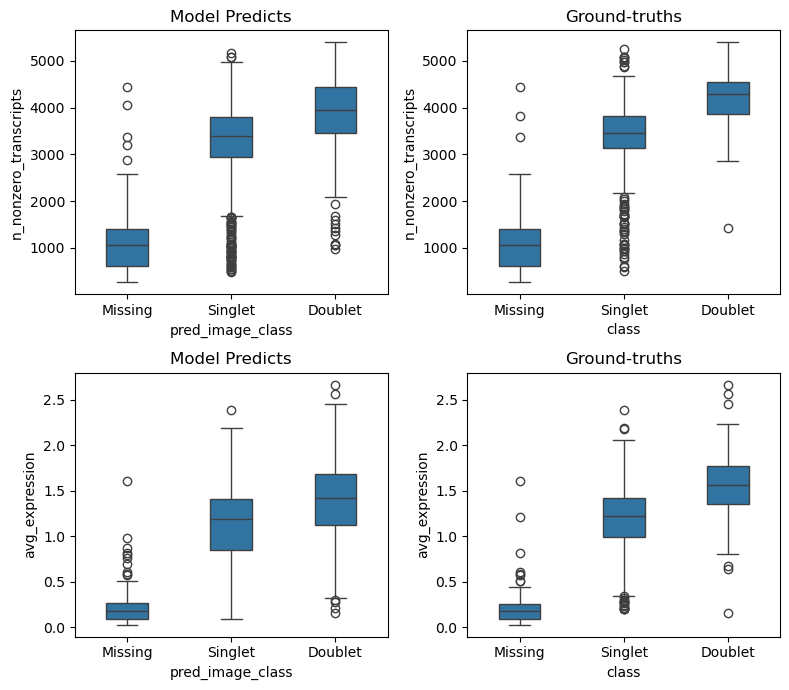

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
sns.boxplot(data=adata.obs, x="pred_image_class", y="n_nonzero_transcripts",
            width = .4, ax=axes[0][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=adata.obs, x="pred_image_class", y="avg_expression",
            width = .4, ax=axes[1][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=adata.obs, x="class", y="n_nonzero_transcripts",
            width = .4, ax=axes[0][1], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=adata.obs, x="class", y="avg_expression",
            width = .4, ax=axes[1][1], order=["Missing", "Singlet", "Doublet"])
for i in range(2):
    axes[i][0].set_title("Model Predicts")
    axes[i][1].set_title("Ground-truths")

plt.tight_layout()
plt.savefig("img5_results.png", dpi=300)

In [32]:
# Image 11
# C1-SUM149-SUM190
# raw_counts = pd.read_csv("./C1-SUM149-SUM190/C1-SUM149-SUM190_gene_raw_count.tsv", sep="\t", index_col=0)
# raw_counts_remove_empty = pd.read_csv("./C1-SUM149-SUM190/C1-SUM149-SUM190_gene_raw_count_remove_empty.tsv", sep="\t")
# expressions = pd.read_csv("./C1-SUM149-SUM190/C1-SUM149-SUM190_gene.tsv", sep="\t", index_col=0)
adata_img11 = process_anndata("../counts/raw_counts_img11_glevel.txt", "Image11", preds)
adata_img11.write_h5ad("adata_img11_wPreds.h5ad")
adata_img11 = process_anndata("../counts/raw_counts_img11_glevel.txt", "Image11", preds_loocv_img11)
adata_img11.write_h5ad("adata_img11_wPreds_fromloocv.h5ad")

In [21]:
preds_loocv_img11

,image_id,image_set,image_pos,pred_image_class
0,Image5_10_1,Image5,COL01_ROW10,Missing
1,Image5_10_10,Image5,COL10_ROW10,Singlet
2,Image5_10_11,Image5,COL11_ROW10,Missing
3,Image5_10_12,Image5,COL12_ROW10,Missing
4,Image5_10_13,Image5,COL13_ROW10,Singlet
...,...,...,...,...
794,Image5_9_5,Image5,COL05_ROW09,Missing
795,Image5_9_6,Image5,COL06_ROW09,Singlet
796,Image5_9_7,Image5,COL07_ROW09,Missing
797,Image5_9_8,Image5,COL08_ROW09,Missing


In [97]:
preds_img11 = merge_with_summary_expression(preds, raw_counts, "Image11")
targets_img11 = merge_with_summary_expression(targets, raw_counts, "Image11")

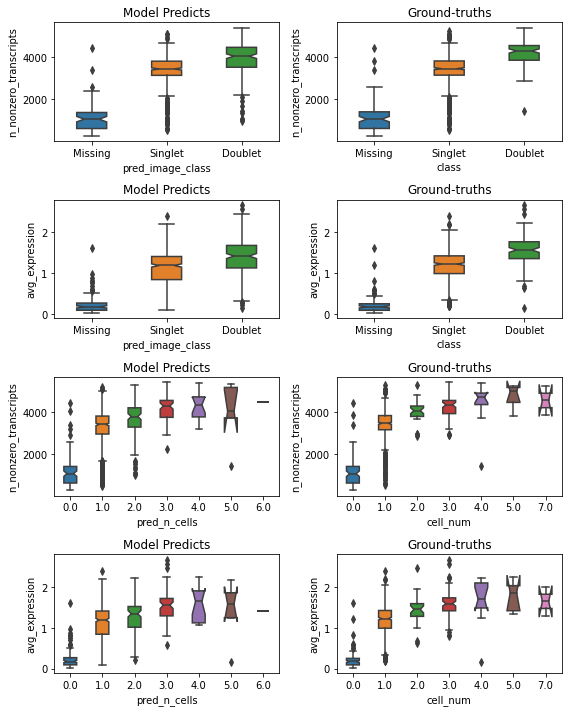

In [77]:
fig, axes = plt.subplots(4, 2, figsize=(8, 10))
sns.boxplot(data=adata_img11.obs[adata_img11.obs.image_id.notnull()], x="pred_image_class", y="n_nonzero_transcripts",
            notch=True, width = .4, ax=axes[0][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=adata_img11.obs, x="pred_image_class", y="avg_expression",
            notch=True, width = .4, ax=axes[1][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=adata_img11.obs, x="pred_n_cells", y="n_nonzero_transcripts",
            notch=True, width = .4, ax=axes[2][0])
sns.boxplot(data=adata_img11.obs, x="pred_n_cells", y="avg_expression",
            notch=True, width = .4, ax=axes[3][0])
sns.boxplot(data=adata_img11.obs, x="class", y="n_nonzero_transcripts",
            notch=True, width = .4, ax=axes[0][1], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=adata_img11.obs, x="class", y="avg_expression",
            notch=True, width = .4, ax=axes[1][1], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=adata_img11.obs, x="cell_num", y="n_nonzero_transcripts",
            notch=True, width = .4, ax=axes[2][1])
sns.boxplot(data=adata_img11.obs, x="cell_num", y="avg_expression",
            notch=True, width = .4, ax=axes[3][1])
for i in range(4):
    axes[i][0].set_title("Model Predicts")
    axes[i][1].set_title("Ground-truths")

plt.tight_layout()